In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

# Part I: Data preparation & analysis

In [2]:
# Load datasets
test_df = pd.read_csv('dataset_Seminar4/test_data.csv')
train_df = pd.read_csv('dataset_Seminar4/train_data.csv')

features = ['LocationNumber', 'RSSI', 'TxLinkSpeed', 'RxLinkSpeed', 'MainAPConnect']
labels = ['TxThroughput', 'AvgPingLatency']

test_df.head()

,LocationNumber,RSSI,TxLinkSpeed,RxLinkSpeed,MainAPConnect,TxThroughput,AvgPingLatency
0,16,-53.19,787.51,653.48,1,15.94,56.30
1,24,-62.79,657.90,592.37,1,17.31,49.78
2,34,-71.16,259.18,178.29,0,2.89,55.83
3,28,-63.99,467.56,375.04,1,17.01,85.71
4,6,-69.29,355.26,313.15,1,14.05,59.40


In [3]:
# Compute mean and standard deviation of each feature
stats = test_df.describe().loc[["mean", "std"]]
stats_train = train_df.describe().loc[["mean", "std"]]

# Display results
stats

,LocationNumber,RSSI,TxLinkSpeed,RxLinkSpeed,MainAPConnect,TxThroughput,AvgPingLatency
mean,18.252500,-62.392752,490.784789,460.786707,0.910833,12.904876,54.679929
std,10.396517,9.574595,242.528150,253.640807,0.285001,4.436742,8.745980


In [4]:
# Seleccionar las columnas numéricas para la normalización
columns_to_scale = ['RSSI', 'TxLinkSpeed', 'RxLinkSpeed', 'TxThroughput', 'AvgPingLatency']

# Aplicar centrado y normalización manualmente con stats
df_scaled = test_df.copy()
df_scaled[columns_to_scale] = (test_df[columns_to_scale] - stats.loc["mean", columns_to_scale]) / stats.loc["std", columns_to_scale]

df_scaled_train = train_df.copy()
df_scaled_train[columns_to_scale] = (train_df[columns_to_scale] - stats_train.loc["mean", columns_to_scale]) / stats_train.loc["std", columns_to_scale]

df_scaled.head()

,LocationNumber,RSSI,TxLinkSpeed,RxLinkSpeed,MainAPConnect,TxThroughput,AvgPingLatency
0,16,0.961164,1.223467,0.759709,1,0.684088,0.185236
1,24,-0.041490,0.689055,0.518778,1,0.992874,-0.560249
2,34,-0.915678,-0.954960,-1.113767,0,-2.257259,0.131497
3,28,-0.166821,-0.095761,-0.338064,1,0.925256,3.547924
4,6,-0.720370,-0.558800,-0.582070,1,0.258100,0.539685


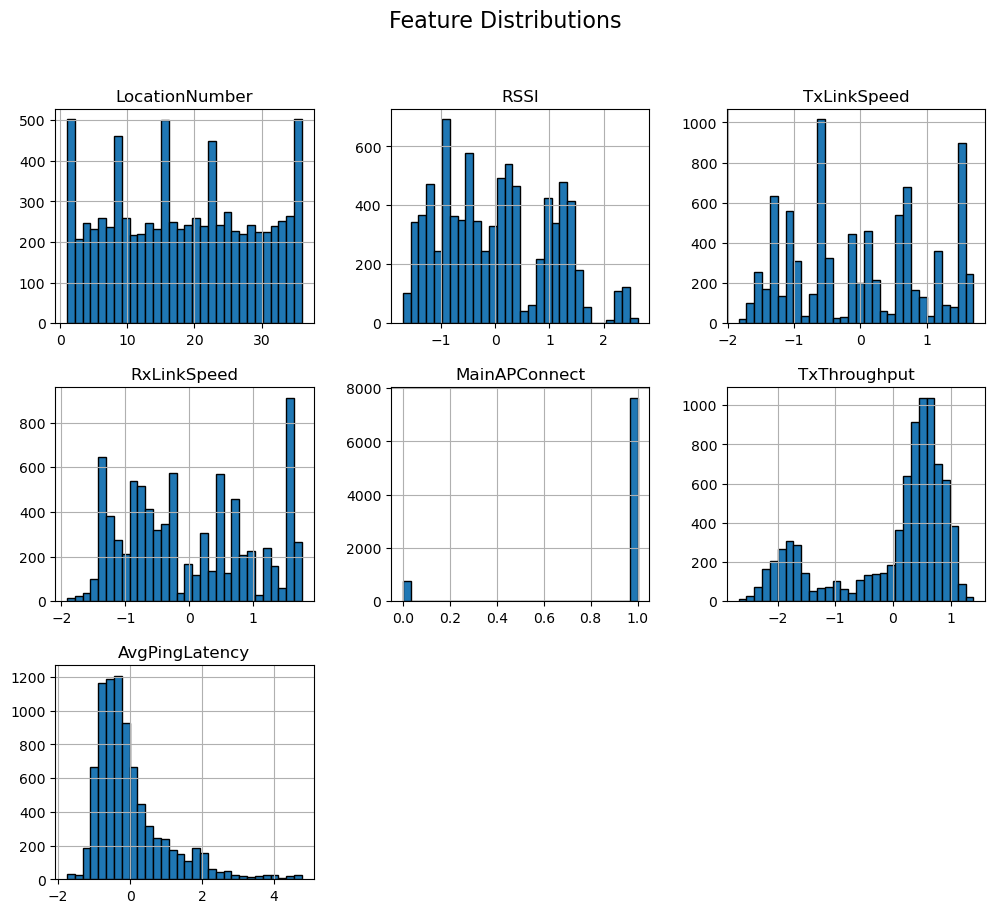

In [5]:
# View distributions

df_scaled.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

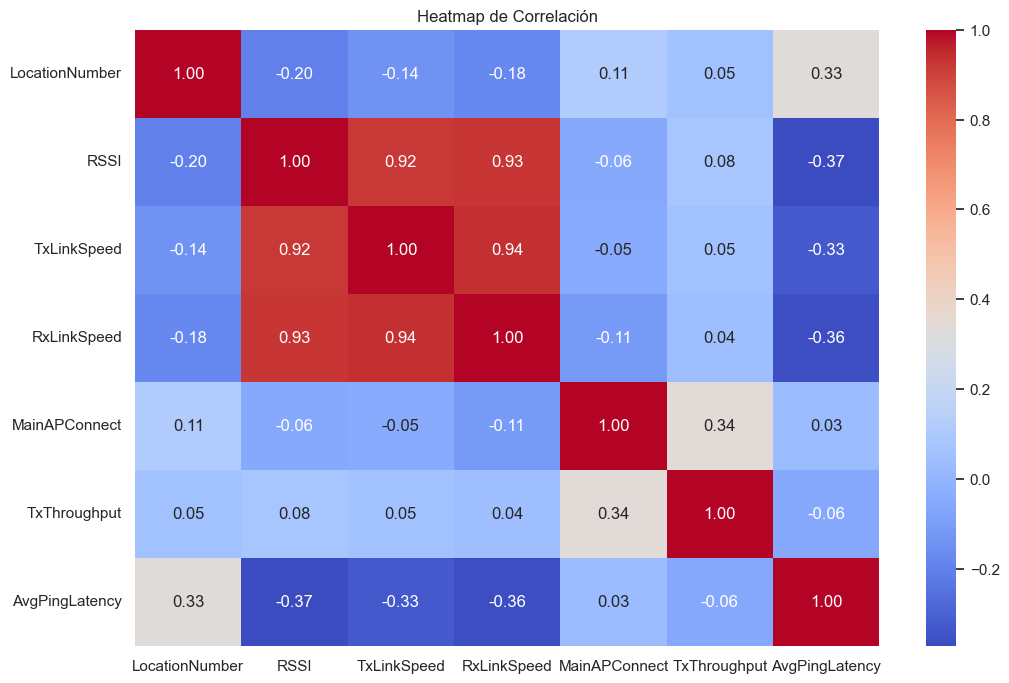

In [31]:
# Calcular la correlación entre todas las variables
correlation_matrix = df_scaled.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap de Correlación")
plt.show()

Negative correlations (feature - label):
- RSSI - AvgPingLatency (numerical feature)
- TxLinkSpeed - AvgPingLatency (numerical feature)
- RxLinkSpeed - AvgPingLatency (numerical feature)

Positive correlations (feature - label):
- MainAPConnect - TxThroughput (cateorical feature)
- LocationNumber - AvgPingLatency (categorical feature)

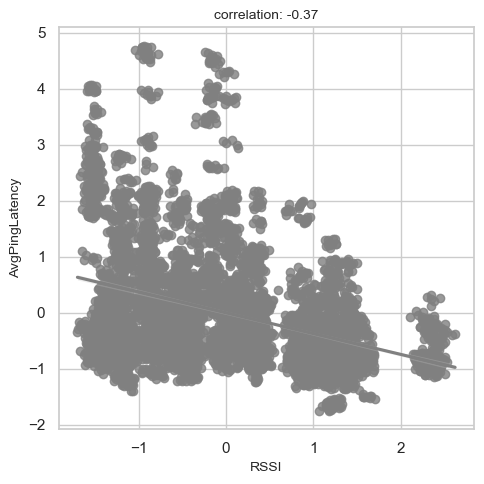

In [32]:
# Plotting liner regression for RSSI vs AvgPingLatency (change this to any of the correlated numerical features seen)

fig, (ax1) = plt.subplots(1, 1)

fig.set_figheight(5)
fig.set_figwidth(5)

sns.set_theme(style="whitegrid")

# RSSI vs AvgPingLatency
sns.regplot(
    data=df_scaled,
    x="RSSI",
    y="AvgPingLatency",
    color="grey",
    ax=ax1
)
s1, p1 = pearsonr(df_scaled["RSSI"], df_scaled["AvgPingLatency"])
ax1.set_title(f"correlation: {round(s1, 2)}", fontsize=10)
ax1.set_xlabel("RSSI", fontsize=10)
ax1.set_ylabel("AvgPingLatency", fontsize=10)

plt.tight_layout()
plt.show()

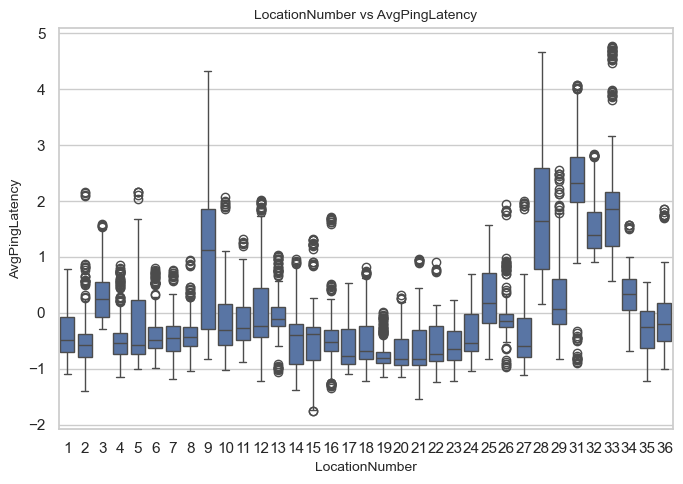

In [33]:
# Plotting boxplot for LocationNumber vs AvgPingLatency 

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(7)

sns.set_theme(style="whitegrid")

sns.boxplot(
    data=df_scaled,
    x="LocationNumber",   # categorical feature
    y="AvgPingLatency",   # numerical label
    # palette="pastel",
    ax=ax
)

ax.set_title("LocationNumber vs AvgPingLatency", fontsize=10)
ax.set_xlabel("LocationNumber", fontsize=10)
ax.set_ylabel("AvgPingLatency", fontsize=10)

plt.tight_layout()
plt.show()


In [34]:
# Group by LocationNumber and calculate mean latency
latency_by_location = df_scaled.groupby("LocationNumber")["AvgPingLatency"].mean()

# Sort values in descending order (highest delay first)
sorted_latency = latency_by_location.sort_values(ascending=False)

# Top 3 with highest delay
print("🚨 Top 3 locations with highest average latency:")
print(sorted_latency.head(3))

# Bottom 3 with lowest delay
print("\n✅ Top 3 locations with lowest average latency:")
print(sorted_latency.tail(3))

🚨 Top 3 locations with highest average latency:
LocationNumber
31    2.231477
33    2.014616
28    1.862395
Name: AvgPingLatency, dtype: float64

✅ Top 3 locations with lowest average latency:
LocationNumber
21   -0.622430
20   -0.704245
19   -0.736491
Name: AvgPingLatency, dtype: float64


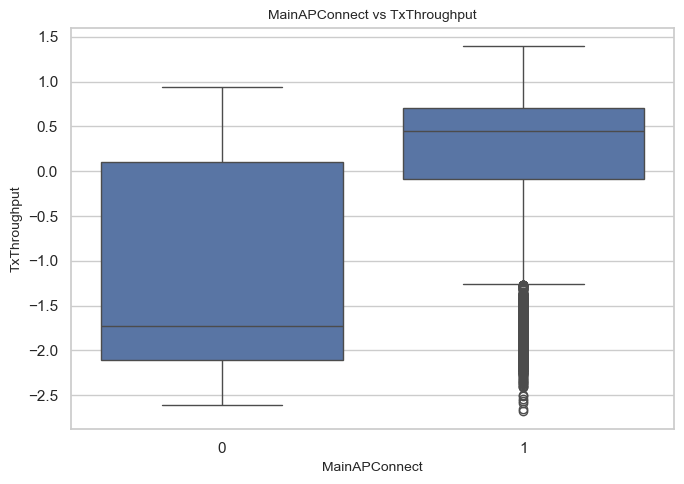

In [35]:
# Plotting boxplot for MainAPConnect vs Throughput

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(7)

sns.set_theme(style="whitegrid")

sns.boxplot(
    data=df_scaled,
    x="MainAPConnect",   # categorical feature
    y="TxThroughput",      # numerical label
    # palette="pastel",
    ax=ax
)

ax.set_title("MainAPConnect vs TxThroughput", fontsize=10)
ax.set_xlabel("MainAPConnect", fontsize=10)
ax.set_ylabel("TxThroughput", fontsize=10)

plt.tight_layout()
plt.show()

We can see more throughput for MainAPConnect = 1.

# 2 Part II: FNN-based performance predictor

Primero, intentamos entrenar un modelo con las dos labels juntas:

In [8]:
# Define features and targets
X_test = df_scaled.drop(columns=['TxThroughput', 'AvgPingLatency'])
Y_test = df_scaled[['TxThroughput', 'AvgPingLatency']]

X_train = df_scaled_train.drop(columns=['TxThroughput', 'AvgPingLatency'])
Y_train = df_scaled_train[['TxThroughput', 'AvgPingLatency']]

In [ ]:
# Convert to PyTorch tensors
# (Convert DataFrames to NumPy arrays first)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32)

In [49]:
X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([33600, 5]),
 torch.Size([33600, 2]),
 torch.Size([8400, 5]),
 torch.Size([8400, 2]))

In [ ]:
# Define the model architecture

class WiFiPerformanceFNN(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, output_dim=2, dropout_prob=0.2):
        super(WiFiPerformanceFNN, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.dropout2 = nn.Dropout(dropout_prob)
        
        self.out = nn.Linear(hidden2, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.out(x)
        return x

In [ ]:
# Instantiate the model

input_dim = X_train_tensor.shape[1]  # number of features after preprocessing
model = WiFiPerformanceFNN(input_dim=input_dim)

In [41]:
# Define loss and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
# Training loop with validation

# Prepare datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Split training dataset into train/val (80/20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * X_batch.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val)
                running_val_loss += val_loss.item() * X_val.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    return train_losses, val_losses

In [ ]:
# Run training
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=100)

Epoch 1/100 - Train Loss: 0.3666, Val Loss: 0.3268
Epoch 2/100 - Train Loss: 0.3387, Val Loss: 0.3182
Epoch 3/100 - Train Loss: 0.3307, Val Loss: 0.3153
Epoch 4/100 - Train Loss: 0.3268, Val Loss: 0.3096
Epoch 5/100 - Train Loss: 0.3228, Val Loss: 0.3065
Epoch 6/100 - Train Loss: 0.3199, Val Loss: 0.3027
Epoch 7/100 - Train Loss: 0.3169, Val Loss: 0.3000
Epoch 8/100 - Train Loss: 0.3140, Val Loss: 0.2963
Epoch 9/100 - Train Loss: 0.3114, Val Loss: 0.2946
Epoch 10/100 - Train Loss: 0.3102, Val Loss: 0.2926
Epoch 11/100 - Train Loss: 0.3067, Val Loss: 0.2960
Epoch 12/100 - Train Loss: 0.3059, Val Loss: 0.2931
Epoch 13/100 - Train Loss: 0.3033, Val Loss: 0.2871
Epoch 14/100 - Train Loss: 0.2991, Val Loss: 0.2825
Epoch 15/100 - Train Loss: 0.2950, Val Loss: 0.2774
Epoch 16/100 - Train Loss: 0.2920, Val Loss: 0.2883
Epoch 17/100 - Train Loss: 0.2891, Val Loss: 0.2732
Epoch 18/100 - Train Loss: 0.2848, Val Loss: 0.2687
Epoch 19/100 - Train Loss: 0.2834, Val Loss: 0.2663
Epoch 20/100 - Train 

Throughput - MSE: 0.7714, MAE: 0.6228, R2: 0.2285
Latency    - MSE: 0.4295, MAE: 0.4528, R2: 0.5705


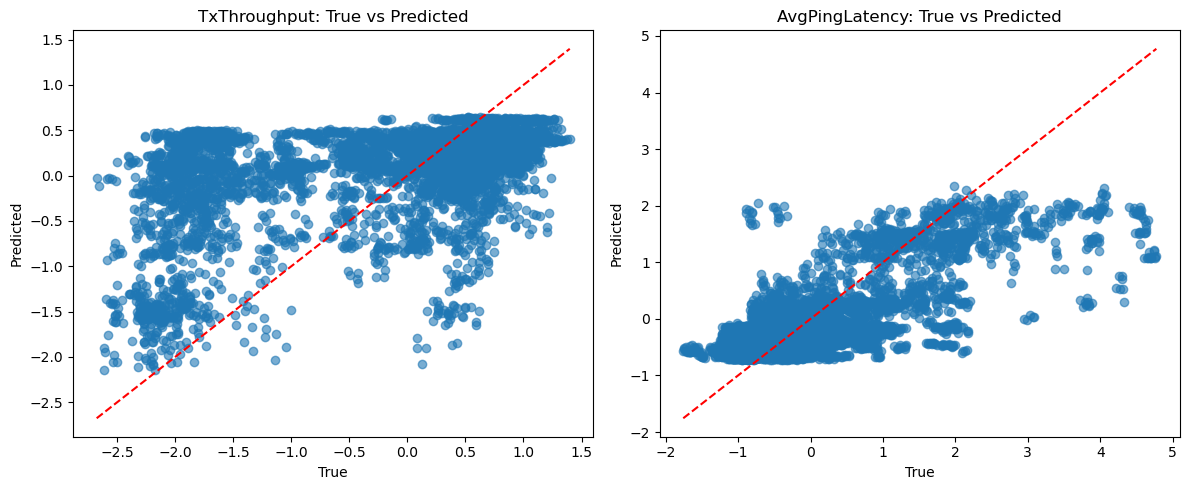

In [ ]:
# Test

# Put model in evaluation mode
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()  # shape: (num_samples, 2)
    y_true = y_test_tensor.numpy()

# Calculate metrics per output
mse_throughput = mean_squared_error(y_true[:, 0], y_pred[:, 0])
mse_latency = mean_squared_error(y_true[:, 1], y_pred[:, 1])

mae_throughput = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
mae_latency = mean_absolute_error(y_true[:, 1], y_pred[:, 1])

r2_throughput = r2_score(y_true[:, 0], y_pred[:, 0])
r2_latency = r2_score(y_true[:, 1], y_pred[:, 1])

print(f"Throughput - MSE: {mse_throughput:.4f}, MAE: {mae_throughput:.4f}, R2: {r2_throughput:.4f}")
print(f"Latency    - MSE: {mse_latency:.4f}, MAE: {mae_latency:.4f}, R2: {r2_latency:.4f}")

# Plot predicted vs true
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(y_true[:, 0], y_pred[:, 0], alpha=0.6)
axs[0].plot([y_true[:, 0].min(), y_true[:, 0].max()], [y_true[:, 0].min(), y_true[:, 0].max()], 'r--')
axs[0].set_title('TxThroughput: True vs Predicted')
axs[0].set_xlabel('True')
axs[0].set_ylabel('Predicted')

axs[1].scatter(y_true[:, 1], y_pred[:, 1], alpha=0.6)
axs[1].plot([y_true[:, 1].min(), y_true[:, 1].max()], [y_true[:, 1].min(), y_true[:, 1].max()], 'r--')
axs[1].set_title('AvgPingLatency: True vs Predicted')
axs[1].set_xlabel('True')
axs[1].set_ylabel('Predicted')

plt.tight_layout()
plt.show()


- R² = 1: El modelo explica perfectamente toda la variabilidad de los datos (predicciones perfectas).
- R² = 0: El modelo no explica nada más que la media (es tan malo como predecir siempre el promedio).
- R² < 0: El modelo es peor que simplemente predecir la media.

Este modelo predice bastante bien Latency pero no el Throughput, a continuación probamos de entrenar dos modelos por separado:

In [ ]:
# Define features and targets for TxThroughput
X_test_1 = df_scaled.drop(columns=['TxThroughput', 'AvgPingLatency'])
Y_test_1 = df_scaled[['TxThroughput']]

X_train_1 = df_scaled_train.drop(columns=['TxThroughput', 'AvgPingLatency'])
Y_train_1 = df_scaled_train[['TxThroughput']]

# Define features and targets for AvgPingLatency
X_test_2 = df_scaled.drop(columns=['TxThroughput', 'AvgPingLatency'])
Y_test_2 = df_scaled[['AvgPingLatency']]

X_train_2 = df_scaled_train.drop(columns=['TxThroughput', 'AvgPingLatency'])
Y_train_2 = df_scaled_train[['AvgPingLatency']]

In [ ]:
# Convert to PyTorch tensors
# (Convert DataFrames to NumPy arrays first)
X_train_tensor_1 = torch.tensor(X_train_1.values, dtype=torch.float32)
y_train_tensor_1 = torch.tensor(Y_train_1.values, dtype=torch.float32)
X_test_tensor_1 = torch.tensor(X_test_1.values, dtype=torch.float32)
y_test_tensor_1 = torch.tensor(Y_test_1.values, dtype=torch.float32)

X_train_tensor_2 = torch.tensor(X_train_2.values, dtype=torch.float32)
y_train_tensor_2 = torch.tensor(Y_train_2.values, dtype=torch.float32)
X_test_tensor_2 = torch.tensor(X_test_2.values, dtype=torch.float32)
y_test_tensor_2 = torch.tensor(Y_test_2.values, dtype=torch.float32)

In [ ]:
# Instantiate the models

input_dim_1 = X_train_tensor_1.shape[1]  # number of features after preprocessing
input_dim_2 = X_train_tensor_2.shape[1]
model_1 = WiFiPerformanceFNN(input_dim=input_dim_1)
model_2 = WiFiPerformanceFNN(input_dim=input_dim_2)

In [ ]:
# Training loop with validation (for TxThroughput)

# Prepare datasets and loaders
train_dataset_1 = TensorDataset(X_train_tensor_1, y_train_tensor_1)

# Split training dataset into train/val (80/20)
train_size_1 = int(0.8 * len(train_dataset_1))
val_size_1 = len(train_dataset_1) - train_size_1
train_ds_1, val_ds_1 = random_split(train_dataset_1, [train_size_1, val_size_1])

train_loader_1 = DataLoader(train_ds_1, batch_size=32, shuffle=True)
val_loader_1 = DataLoader(val_ds_1, batch_size=32)

# Define loss and optimizer
criterion = nn.MSELoss() # en este caso mse va mejor que mae
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

# Run training
train_losses_1, val_losses_1 = train_model(model_1, criterion, optimizer, train_loader_1, val_loader_1, epochs=100)

/Users/albayerga/anaconda3/envs/fate_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:933: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Epoch 1/100 - Train Loss: 0.3213, Val Loss: 0.3105
Epoch 2/100 - Train Loss: 0.3227, Val Loss: 0.3074
Epoch 3/100 - Train Loss: 0.3217, Val Loss: 0.3072
Epoch 4/100 - Train Loss: 0.3208, Val Loss: 0.3093
Epoch 5/100 - Train Loss: 0.3187, Val Loss: 0.3114
Epoch 6/100 - Train Loss: 0.3204, Val Loss: 0.3096
Epoch 7/100 - Train Loss: 0.3212, Val Loss: 0.3078
Epoch 8/100 - Train Loss: 0.3210, Val Loss: 0.3104
Epoch 9/100 - Train Loss: 0.3178, Val Loss: 0.3087
Epoch 10/100 - Train Loss: 0.3207, Val Loss: 0.3065
Epoch 11/100 - Train Loss: 0.3206, Val Loss: 0.3180
Epoch 12/100 - Train Loss: 0.3192, Val Loss: 0.3044
Epoch 13/100 - Train Loss: 0.3184, Val Loss: 0.3065
Epoch 14/100 - Train Loss: 0.3185, Val Loss: 0.3135
Epoch 15/100 - Train Loss: 0.3195, Val Loss: 0.3055
Epoch 16/100 - Train Loss: 0.3173, Val Loss: 0.3061
Epoch 17/100 - Train Loss: 0.3186, Val Loss: 0.3111
Epoch 18/100 - Train Loss: 0.3196, Val Loss: 0.3039
Epoch 19/100 - Train Loss: 0.3179, Val Loss: 0.3058
Epoch 20/100 - Train 

In [ ]:
# Training loop with validation (for AvgPingLatency)

# Prepare datasets and loaders
train_dataset_2 = TensorDataset(X_train_tensor_2, y_train_tensor_2)

# Split training dataset into train/val (80/20)
train_size_2 = int(0.8 * len(train_dataset_2))
val_size_2 = len(train_dataset_2) - train_size_2
train_ds_2, val_ds_2 = random_split(train_dataset_2, [train_size_2, val_size_2])

train_loader_2 = DataLoader(train_ds_2, batch_size=32, shuffle=True)
val_loader_2 = DataLoader(val_ds_2, batch_size=32)

# Define loss and optimizer
criterion = nn.SmoothL1Loss() # va un poco mejor que el MSE en este caso (hay más outliers)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Run training
train_losses_2, val_losses_2 = train_model(model_2, criterion, optimizer, train_loader_2, val_loader_2, epochs=100)

/Users/albayerga/anaconda3/envs/fate_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:933: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Epoch 1/100 - Train Loss: 0.1832, Val Loss: 0.1733
Epoch 2/100 - Train Loss: 0.1826, Val Loss: 0.1772
Epoch 3/100 - Train Loss: 0.1826, Val Loss: 0.1749
Epoch 4/100 - Train Loss: 0.1816, Val Loss: 0.1776
Epoch 5/100 - Train Loss: 0.1836, Val Loss: 0.1762
Epoch 6/100 - Train Loss: 0.1827, Val Loss: 0.1744
Epoch 7/100 - Train Loss: 0.1820, Val Loss: 0.1748
Epoch 8/100 - Train Loss: 0.1855, Val Loss: 0.1743
Epoch 9/100 - Train Loss: 0.1825, Val Loss: 0.1737
Epoch 10/100 - Train Loss: 0.1821, Val Loss: 0.1748
Epoch 11/100 - Train Loss: 0.1830, Val Loss: 0.1770
Epoch 12/100 - Train Loss: 0.1815, Val Loss: 0.1748
Epoch 13/100 - Train Loss: 0.1818, Val Loss: 0.1759
Epoch 14/100 - Train Loss: 0.1804, Val Loss: 0.1740
Epoch 15/100 - Train Loss: 0.1807, Val Loss: 0.1727
Epoch 16/100 - Train Loss: 0.1808, Val Loss: 0.1771
Epoch 17/100 - Train Loss: 0.1815, Val Loss: 0.1732
Epoch 18/100 - Train Loss: 0.1807, Val Loss: 0.1771
Epoch 19/100 - Train Loss: 0.1823, Val Loss: 0.1799
Epoch 20/100 - Train 

In [ ]:
# Put model in evaluation mode
model_1.eval()

with torch.no_grad():
    y_pred_1 = model_1(X_test_tensor_1).numpy()
    y_true_1 = y_test_tensor_1.numpy()

# Calculate metrics per output
mse_throughput = mean_squared_error(y_true_1[:, 0], y_pred_1[:, 0])
mae_throughput = mean_absolute_error(y_true_1[:, 0], y_pred_1[:, 0])
r2_throughput = r2_score(y_true_1[:, 0], y_pred_1[:, 0])
print(f"Throughput - MSE: {mse_throughput:.4f}, MAE: {mae_throughput:.4f}, R2: {r2_throughput:.4f}")

Throughput - MSE: 0.7211, MAE: 0.6160, R2: 0.2788


In [ ]:
# Put model in evaluation mode
model_2.eval()

with torch.no_grad():
    y_pred_2 = model_2(X_test_tensor_2).numpy()
    y_true_2 = y_test_tensor_2.numpy()

# Calculate metrics per output
mse_throughput = mean_squared_error(y_true_2[:, 0], y_pred_2[:, 0])
mae_throughput = mean_absolute_error(y_true_2[:, 0], y_pred_2[:, 0])
r2_throughput = r2_score(y_true_2[:, 0], y_pred_2[:, 0])
print(f"AvgPingLatency - MSE: {mse_throughput:.4f}, MAE: {mae_throughput:.4f}, R2: {r2_throughput:.4f}")

AvgPingLatency - MSE: 0.3808, MAE: 0.4349, R2: 0.6192


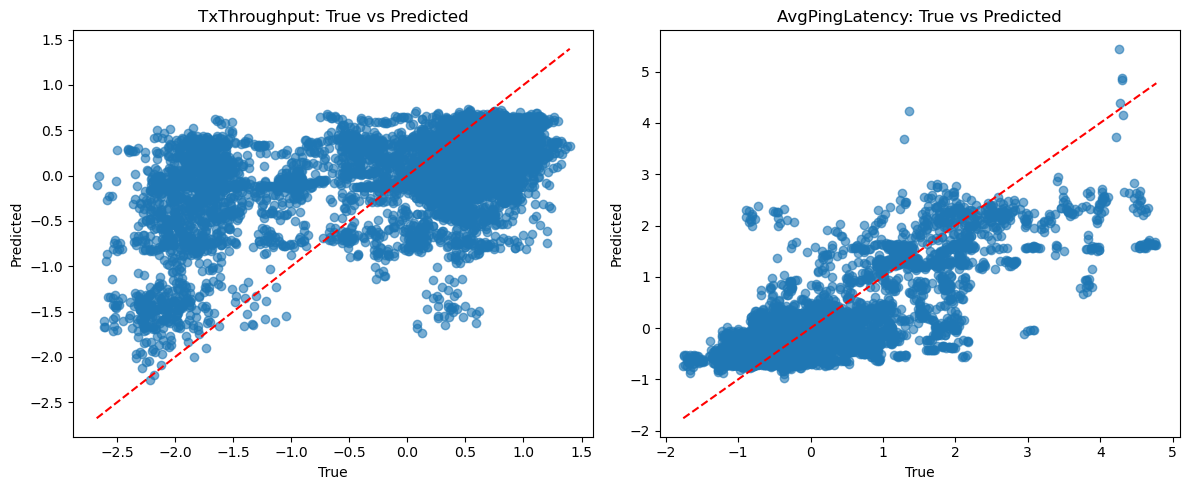

In [44]:
# Plot predicted vs true
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(y_true_1[:, 0], y_pred_1[:, 0], alpha=0.6)
axs[0].plot([y_true_1[:, 0].min(), y_true_1[:, 0].max()], [y_true_1[:, 0].min(), y_true_1[:, 0].max()], 'r--')
axs[0].set_title('TxThroughput: True vs Predicted')
axs[0].set_xlabel('True')
axs[0].set_ylabel('Predicted')

axs[1].scatter(y_true_2[:, 0], y_pred_2[:, 0], alpha=0.6)
axs[1].plot([y_true_2[:, 0].min(), y_true_2[:, 0].max()], [y_true_2[:, 0].min(), y_true_2[:, 0].max()], 'r--')
axs[1].set_title('AvgPingLatency: True vs Predicted')
axs[1].set_xlabel('True')
axs[1].set_ylabel('Predicted')


plt.tight_layout()
plt.show()

Vemos que los modelos mejoran un poco por separado pero tampoco mucho, ya que hemos aplicado el mismo entrenamiento prácticamente (aunque hemos probado diferentes loss functions para los modelos separados).